In [1]:
from basic_imports import *
from torch_imports import *
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [2]:
# data = pd.read_csv('data_raw.csv')
# data_f = pd.read_csv('data_filtered.csv', encoding='latin1')

In [3]:
# all_letters = string.ascii_letters + "0123456789 .,:!?'[]()/+-="
# def get_data():
#     category_lines = {}
#     all_categories = ['st']
#     category_lines['st']=[]
#     filterwords=['NEXTEPISODE']
#     with open('./data_filtered.csv', newline='') as csvfile:
#         reader = csv.reader(csvfile, delimiter=',', quotechar='"')
#         for row in reader:
#             for el in row:
#                 if (el not in filterwords) and (len(el)>1):
# #                     print(el)
#                     v=el.strip().replace(';','').replace('\"','')
#                     category_lines['st'].append(v)
#                     n_categories = len(all_categories)
#     print(len(all_categories), len(category_lines['st']))
#     print('done')
#     return category_lines,all_categories

In [4]:
class Config:
    data_dir = 'data_raw.csv'
    batch_size = 64
    hidden_dim = 200
    lr = 5e-3
    device = 'cuda:2'
    num_layers = 2
    num_epochs = 3
config = Config()

## Clean data

In [5]:
data = pd.read_csv(config.data_dir)

In [6]:
data_clean = []

for o in data.values:
    for oo in o:
        if type(oo) == float or oo == "NEXTEPISODE":
            continue
        if oo[0] == '(':
            continue
        data_clean.append(oo)

In [7]:
idx2char = ['[PAD]', '[EOS]', '[SOS]', ]
idx2char += list(set([character for line in data_clean for character in line]))
char2idx = {o:i for i,o in enumerate(idx2char)}

In [8]:
# class StarTrekDataset(Dataset):
#     def __init__(self, data, vocab):
#         self.data = data
#         self.vocab = vocab
    
#     def __getitem__(self, i):
#         return [self.vocab[o] for o in self.data[i]] + [self.vocab['[EOS]']]
    
#     def __len__(self):
#         return len(self.data)

class StarTrekDataset(Dataset):
    def __init__(self, data, vocab, batch_len=17):
        self.data = data
        self.vocab = vocab
        self.batch_len = batch_len
        self.get_sequences()
        
    def __getitem__(self, i):
        return self.data[i]
    
    def __len__(self):
        return len(self.data)

    def get_sequences(self):
        seqs = [ ['[SOS]']+list(o)+['[EOS]'] for o in self.data]
        seqs = [oo for o in seqs for oo in o]
        sequences = []
        for i in progress_bar(range(len(seqs)-self.batch_len)):
            sequences.append([self.vocab[o] for o in seqs[i:i+self.batch_len]])
        self.data = sequences

In [9]:
data_train, data_val = np.split(data_clean, [int(len(data_clean)*0.8)])

## Dataset and Dataloader

In [10]:
ds_trn = StarTrekDataset(data_train, char2idx)
ds_val = StarTrekDataset(data_val, char2idx)

In [11]:
# ''.join([idx2char[o] for o in ds_trn[5]])

In [12]:
# def collate_fn(batch):
#     lens = [len(o) for o in batch]
#     max_len = max(lens)
#     cum_len = np.cumsum(lens)
#     seq_batch = np.zeros((cum_len[-1], max_len))
#     seq_lens = np.zeros(cum_len[-1])
#     y = np.zeros(cum_len[-1])
    
#     seq_batch[:,0] = np.ones(cum_len[-1]) * char2idx['[SOS]']
    
#     start_cum = 0
#     for ui,utter in enumerate(batch):
#         seq_lens[start_cum: cum_len[ui]] = np.arange(lens[ui]) + 1
#         for i in range(1, lens[ui]+1):
#             seq_batch[start_cum+i-1, 1:i] = np.array(utter[:i-1])
#             y[start_cum+i-1] = utter[i-1]
#         start_cum = cum_len[ui]
    
#     idx = np.argsort(seq_lens)[::-1]
#     seq_batch, seq_lens, y = seq_batch[idx], seq_lens[idx], y[idx]
#     return torch.Tensor(seq_batch).long(), torch.Tensor(seq_lens).long(), torch.Tensor(y).long()


def collate_fn(batch):
    batch = np.array(batch)
    return torch.from_numpy(batch[:,:-1]).long(), torch.from_numpy(batch[:,1:]).long()

In [13]:
dl_trn = DataLoader(ds_trn, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=config.batch_size, collate_fn=collate_fn, shuffle=False)

In [14]:
# torch.set_printoptions(threshold=100)
# torch.set_printoptions(edgeitems=100)

## Model

In [20]:
# class Model(nn.Module):
#     def __init__(self, input_size, hidden_dim, vocab_size, layers):
#         super().__init__()
#         self.embedding = nn.Embedding(input_size, hidden_dim)
#         self.lstm = nn.LSTM(hidden_dim, hidden_dim, layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, out_features=vocab_size)
        
#     def forward(self, inputs):
#         x, seq_lens = inputs
#         x = self.embedding(x)
#         x_packed = pack_padded_sequence(x, seq_lens, batch_first=True)
#         y_packed, (h, c) = self.lstm(x_packed)
#         y, _ = pad_packed_sequence(y_packed, batch_first=True)
#         y_last = torch.stack([y[i,seq_lens[i]-1,:] for i in range(len(x))])
#         return y_last

class Model(nn.Module):
    def __init__(self, input_size, hidden_dim, vocab_size, layers, model_path='model.pt'):
        super().__init__()
        self.embedding = nn.Embedding(input_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_features=vocab_size)
        self.dropout = nn.Dropout(p=0.1)
        self.model_path = Path(model_path)
        if self.model_path.exists():
            self.load_state_dict(torch.load(self.model_path))
    def forward(self, inputs, states=None):
        x = inputs
        x = self.embedding(x)
        y, states = self.lstm(x, states)
        y_last = self.dropout(y)
        y_last = self.fc(y_last)
        return y_last, states
    
model = Model(len(char2idx), config.hidden_dim, len(char2idx), config.num_layers)
model = model.to(config.device)

## Optimizer and Criterion

In [21]:
criterion = nn.CrossEntropyLoss()

## Train

In [22]:
# class Generate_StarTrek_Dialogue:
#     def __init__(self, vocab, model, )

In [27]:
# def train(model, dl, optimizer, criterion, num_instances, train=True):
#     if train:
#         model.train()
#     else:
#         model.eval()
#     loss, acc = 0, 0
    
#     for X, seq_lens, y in dl:
#         X = X.to(config.device)
#         seq_lens = seq_lens.to(config.device)
#         labels = y.to(config.device)
#         optimizer.zero_grad()
        
#         with torch.set_grad_enabled(train):
#             outputs = model( (X, seq_lens) )
#             preds = outputs.argmax(dim=1)
#             l = criterion(outputs, labels)
#             if train:
#                 l.backward()
#                 optimizer.step()
#         loss += l.item()
#         print(l.item())
#         acc += torch.sum(preds == labels).item()
#     loss /= len(dl)
#     acc /= num_instances
#     return loss, acc

def train(model, dl, optimizer, criterion, num_instances, train=True):
    if train:
        model.train()
    else:
        model.eval()
    loss, acc = 0, 0
    
    for ibatch, (X, y) in enumerate(dl):
        X = X.to(config.device)
        labels = y.to(config.device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            outputs, states = model( X )
            outputs = outputs.reshape(-1, len(char2idx))
            labels = labels.reshape(-1)
            preds = outputs.argmax(dim=1)
            l = criterion(outputs, labels)
            if train:
                l.backward()
                optimizer.step()
        loss += l.item()
#         if ibatch % 1000 == 0: print(l.item())
        acc += torch.sum(preds == labels).item()
    loss /= len(dl)
    acc /= num_instances
    return loss, acc


def fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion):
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
    best_acc = 0
    trn_losses, val_losses, val_accs = [], [], []
    for epoch in range(config.num_epochs):
        # train
        trn_loss, trn_acc = train(model, dl_trn, optimizer, criterion, len(ds_trn), train=True)
        # val
        val_loss, val_acc = train(model, dl_val, optimizer, criterion, len(ds_val), train=False)
        trn_losses.append(trn_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = model.state_dict()
            best_epoch = epoch
        print(f'Epoch {epoch}/{config.num_epochs - 1}, trn_loss {trn_loss} val_loss {val_loss} val_acc {val_acc}')
    return best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs]

In [28]:
best_weights, best_epoch, [best_acc, trn_losses, val_losses, val_accs] = fit(ds_trn, ds_val, dl_trn, dl_val, model, criterion)

Epoch 0/2, trn_loss 2.356958245012336 val_loss 1.9785786063831743 val_acc 7.062528668739909
Epoch 1/2, trn_loss 1.9111777491344473 val_loss 1.7980244421456373 val_acc 7.640407616438024
Epoch 2/2, trn_loss 1.775312527735602 val_loss 1.7061766203356548 val_acc 7.980273886238399


In [29]:
torch.save(best_weights, 'model.pt')
# model.load_state_dict(torch.load('model.pt'))

## Inference

In [32]:
def sample(num):
    states = None
    x = torch.ones(num, 1).long().to(config.device)*char2idx['[SOS]']
    history = [x]
    for _ in range(40):
        logits, states = model(history[-1], states)
        predicts = torch.multinomial(torch.softmax(logits.squeeze(), dim=-1), num_samples=1)
        history.append(predicts)
    return torch.stack(history).squeeze().transpose(0, 1)

## Performance

In [34]:
s = sample(3).cpu().numpy()

In [38]:
''.join([idx2char[o] for o in s[2]])

'[SOS]SPOCK: Yes, sir?[EOS][SOS]KERT: Echise you.[EOS][SOS]VUU'

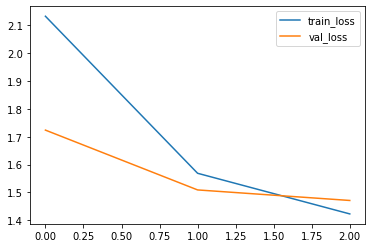

In [29]:
plt.plot(np.arange(3), trn_losses, label='train_loss')
plt.plot(np.arange(3), val_losses, label='val_loss')
plt.legend()
plt.savefig('losses.png')

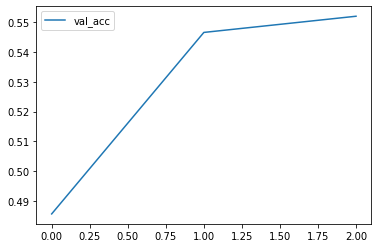

In [31]:
plt.plot(np.arange(3), val_accs, label='val_acc')
plt.legend()
plt.savefig('val_accuracy.png')